In [1]:
# This notebook is for calculating the geodic distance and connectivity distance of functional and structural matrices 
# Includes:
#      loading geodesic distance map and visualize
#      loading myelin map and visualize
#      loading functional and structural conn matrices and visualize / compare with geodesic
#      correlation between geodesic, myelin map and func / struct
#      spin test (whole brain / parcellated brain) correlation

In [1]:
import os
from neuromaps import images
import numpy as np
import nibabel as nib
from sklearn import preprocessing
from surfplot import Plot
from neuromaps.datasets import fetch_fsaverage
from numpy import load
import seaborn as sns
import matplotlib.pyplot as plt
from neuromaps import stats
from neuromaps import datasets, images, nulls, resampling
from neuromaps import parcellate
from brainspace.datasets import load_fsa5
from brainspace.plotting import plot_hemispheres
from brainspace.datasets import load_parcellation
from brainspace.utils.parcellation import map_to_labels
import pandas as pd

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


### Setting path

In [2]:
main_path = "/srv/khan/users/sudesnac/"
#main_path = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/21_Codes/"

In [3]:
note_path = main_path + "/HumanBF-Parcellation/notebook/"
data_path = main_path + "/HumanBF-Parcellation/data/"
results_path = main_path + "/HumanBF-Parcellation/results/Conn_dist/"
fig_path = main_path + "/HumanBF-Parcellation/results/figures/Conn_dist/"

### Load & visualize geodic distance (pial)

In [4]:
# Geodic Distance
# data_dir = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/13_Funcparc/0_Funcparc_rhaast/basal_forebrain/resources/"
geodic_lh = images.load_gifti(results_path + "seed-BASF_geodesic-distance-no-zeros.pial.lh.shape.gii")
geodic_rh = images.load_gifti(results_path + "seed-BASF_geodesic-distance-no-zeros.pial.rh.shape.gii")

In [5]:
geodic_lh_data = geodic_lh.agg_data()
geodic_rh_data = geodic_rh.agg_data()
geodic_data = np.concatenate((geodic_lh_data, geodic_rh_data))

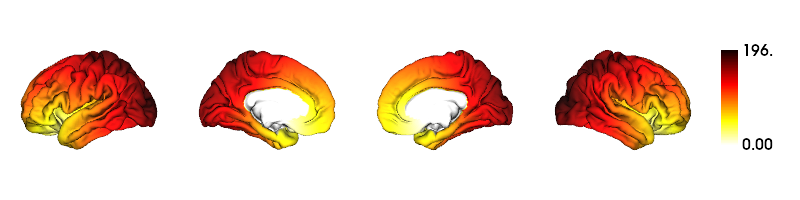

In [6]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[geodic_data], size=(800, 200), cmap=['hot_r'], color_bar=True, embed_nb=True)

In [7]:
# getting the surface BF data
# seed_dir = "/home/ROBARTS/schakraborty/graham/sudesnacPJ/13_Funcparc/0_Funcparc_rhaast/basal_forebrain/results/funcparc_icafix/group/atlas/"
BF_lh = images.load_gifti(results_path + "seed-BASF.L.bin.fsa5.shape.gii")
BF_rh = images.load_gifti(results_path + "seed-BASF.R.bin.fsa5.shape.gii")

In [8]:
BF_lh_data = BF_lh.agg_data()
BF_rh_data = BF_rh.agg_data()
BF_data = np.concatenate((BF_lh_data, BF_rh_data))

In [77]:
# scale the geodic and BF data 
min_max_scaler = preprocessing.MinMaxScaler()
BF_scaled_data = min_max_scaler.fit_transform(BF_data.reshape(-1, 1))
geodic_scaled_data = min_max_scaler.fit_transform(geodic_data.reshape(-1, 1))

In [78]:
np.where(BF_scaled_data == 1)

(array([11428, 16986]), array([0, 0]))

In [79]:
# for displaying all values in numpy
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [80]:
# change so the scaled data is binarized
BF_scaled_data = np.where(BF_scaled_data == 0.5, 1, BF_scaled_data)
np.where(BF_scaled_data==1)

(array([   78,   600,  1335,  1337,  2438,  3255,  3256,  3257,  5448,
         5452,  7014,  7015,  8476,  8477,  9873,  9874,  9875,  9878,
         9879,  9880, 10324, 10443, 11205, 11206, 11428, 11754, 11755,
        11756, 11757, 11758, 13125, 13126, 13723, 13728, 14570, 14571,
        14572, 15678, 16583, 16584, 16585, 16986, 17610, 17612, 17613,
        17614, 17616, 17617, 17618, 17619, 17620, 18752, 20086, 20087,
        20095, 20096]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

/tmp/ipykernel_7862/1614111137.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


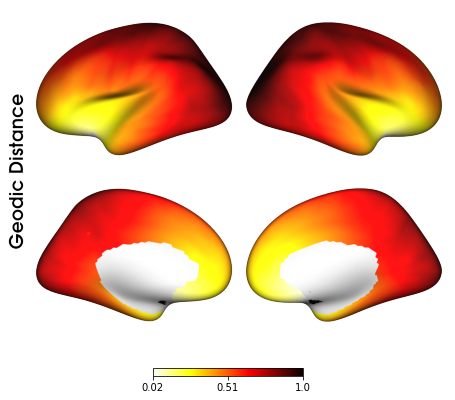

In [13]:
# plot both BF and geodic distance together

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Geodic Distance']}, brightness=.8)
p.add_layer(geodic_scaled_data.reshape([20484]), cmap='hot_r', cbar=True)
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
fig.savefig(fig_path+'geodesic_dist_BFseed_grid.png', dpi=300)

### Load & visualize average T1w/T2w (Myelin Maps)

In [14]:
myelin_lh = images.load_gifti(results_path + "source-hcps1200_desc-myelinmap_space-fsaverage5_den-10k_hemi-L_feature.func.gii")
myelin_rh = images.load_gifti(results_path + "source-hcps1200_desc-myelinmap_space-fsaverage5_den-10k_hemi-R_feature.func.gii")

In [15]:
myelin_lh_data = myelin_lh.agg_data()
myelin_rh_data = myelin_rh.agg_data()
myelin_data = np.concatenate((myelin_lh_data, myelin_rh_data))

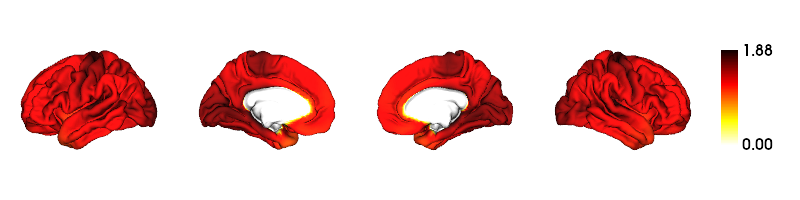

In [16]:
# Checking the cortical surface data
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[myelin_data], size=(800, 200), cmap=['hot_r'], color_bar=True, embed_nb=True)

In [76]:
myelin_scaled_data = min_max_scaler.fit_transform(myelin_data.reshape(-1, 1))

/tmp/ipykernel_7862/2383120645.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


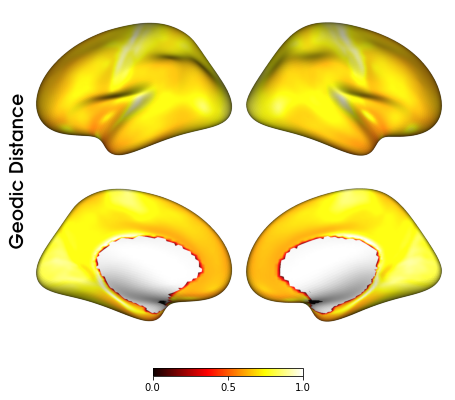

In [18]:
# plot both BF and myelin map together

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Geodic Distance']}, brightness=.8)
p.add_layer(myelin_scaled_data.reshape([20484]), cmap='hot', cbar=True)
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
fig = p.build()
fig.show()
fig.savefig(fig_path+'myelin_map_BFseed_grid.png', dpi=300)

### Loading functional and diffusion connectivity data

#### Functional data

In [19]:
from numpy import load
# load npz data
func_data = load(data_path + 'correlation_matrix_HCP-MMP_group.npz')
func_correlation = func_data['corr_group']
func_indices = func_data['indices']

In [20]:
# Average correlation matrix
corr_avg = np.nanmean(func_correlation,axis=0)
corr_avg += 1
corr_avg[np.isnan(corr_avg)] = 1
# remove the subcortical regions 
func_corr_avgFC = corr_avg[:,:-19]

In [21]:
func_ctx = np.nanmean(func_corr_avgFC,axis=0).reshape([360,1])

#### Diffusion data

In [22]:
diff_data = load(data_path + 'tpl-MNI152NLin6Asym_label-fullBF_desc-concat_from-7Tsubj7TDWI_connMap-modified.npz')
dcorrelation = diff_data['conn_group']

In [23]:
# Average correlation matrix
dcorr_avg = np.nanmean(dcorrelation,axis=0)
dcorr_avg += 1
dcorr_avg[np.isnan(dcorr_avg)] = 1

In [24]:
dcorr_avgFC = np.concatenate((dcorr_avg,dcorr_avg), axis=1)
log_dcorr_avgFC = np.log(dcorr_avgFC)

In [25]:
diff_ctx = np.nanmean(log_dcorr_avgFC,axis=0).reshape([360,1])

In [27]:
dcorrelation[:,:,80].shape

(173, 7142)

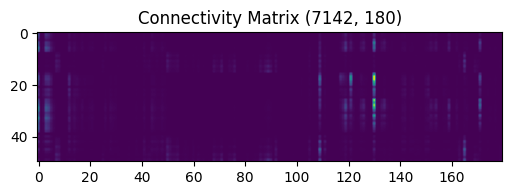

In [26]:
# Plot this matrix.
f, ax = plt.subplots(1,1,dpi=100)
ax.imshow(dcorr_avg[:50])
ax.set_title('Connectivity Matrix {}'.format(dcorr_avg.shape))
plt.show()

#### Visualize

In [27]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [28]:
func_cortex = map_to_labels(func_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)
diff_cortex = map_to_labels(diff_ctx.reshape([360]),surf_labels, mask=mask, fill=np.nan)

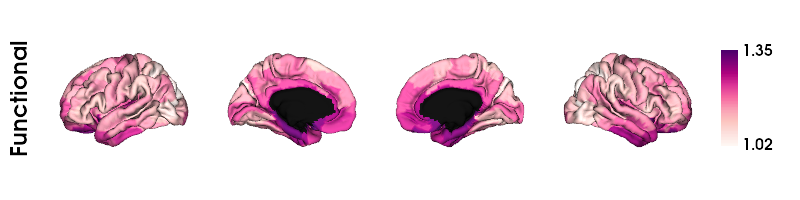

In [29]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[func_cortex], size=(800, 200), cmap=['RdPu'], label_text=['Functional'], color_bar=True, embed_nb=True)

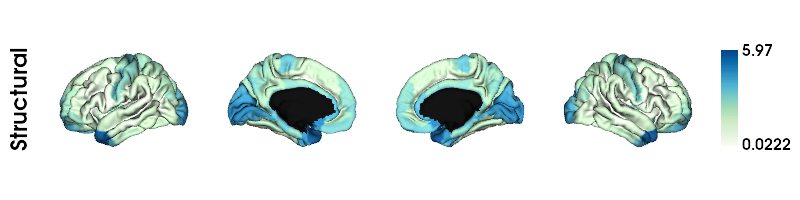

In [30]:
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[diff_cortex], size=(800, 200), cmap=['GnBu'], label_text=['Structural'], color_bar=True, embed_nb=True)

#### Rescale data

In [81]:
# scale the  data 
min_max_scaler = preprocessing.MinMaxScaler()
func_scaled_ctx = min_max_scaler.fit_transform(func_cortex.reshape(-1, 1))
diff_scaled_ctx = min_max_scaler.fit_transform(diff_cortex.reshape(-1, 1))

In [82]:
gdist_data = {'labels':surf_labels.reshape([20484]), 'geodesic':geodic_scaled_data.reshape([20484]), 'myelin':myelin_scaled_data.reshape([20484]), 'functional':func_scaled_ctx.reshape([20484]), 'structural':diff_scaled_ctx.reshape([20484])}
gdist_df = pd.DataFrame(data=gdist_data)

In [83]:
gdist_df.head(10)

,labels,geodesic,myelin,functional,structural
0,54,0.796473,0.854568,0.469834,0.386056
1,46,0.911204,0.691224,0.210992,0.379450
2,41,0.564919,0.721838,0.521383,0.104395
3,87,0.552300,0.641402,0.341724,0.388843
4,99,0.450188,0.707502,0.377407,0.119951
5,149,0.708620,0.657952,0.319306,0.236687
6,6,0.846829,0.774055,0.269942,0.495728
7,121,0.613734,0.725570,0.589872,0.423227
8,0,0.000000,0.000000,NaN,NaN
9,111,0.167580,0.651792,0.514393,0.050101


In [84]:
# set the geodesic medial wall to nan instead of 0 to match with other 
gdist_df.loc[gdist_df.labels == 0, 'geodesic'] = np.nan
gdist_df.loc[gdist_df.labels == 0, 'myelin'] = np.nan
gdist_df.loc[gdist_df.labels == 0, 'functional'] = np.nan
gdist_df.loc[gdist_df.labels == 0, 'structural'] = np.nan

In [85]:
gdist_df.loc[gdist_df.labels == 80, 'structural'] = 0.000001
gdist_df.loc[gdist_df.labels == 260, 'structural'] = 0.000001
gdist_df.loc[gdist_df.labels == 16, 'functional'] = 0.000001

In [89]:
#pd.set_option('display.max_rows', None)
gdist_df.loc[(gdist_df['functional'] == 0.000001)]

,labels,geodesic,myelin,functional,structural
302,16,0.912674,0.806342,0.000001,0.357478
782,16,0.945906,0.801276,0.000001,0.357478
1696,16,0.874996,0.786361,0.000001,0.357478
1933,16,0.887666,0.771936,0.000001,0.357478
1934,16,0.925222,0.786064,0.000001,0.357478
1935,16,0.955813,0.776769,0.000001,0.357478
3787,16,0.895076,0.798322,0.000001,0.357478
4248,16,0.915721,0.767116,0.000001,0.357478
4249,16,0.933029,0.768125,0.000001,0.357478
4250,16,0.941639,0.784814,0.000001,0.357478


In [90]:
pd.DataFrame(gdist_df).to_csv(results_path + 'rescaled_geodesic_myelin_func_struct_data.csv', index=False)

In [91]:
gdist_df = pd.read_csv(results_path + 'rescaled_geodesic_myelin_func_struct_data.csv')

/tmp/ipykernel_7862/1535874465.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


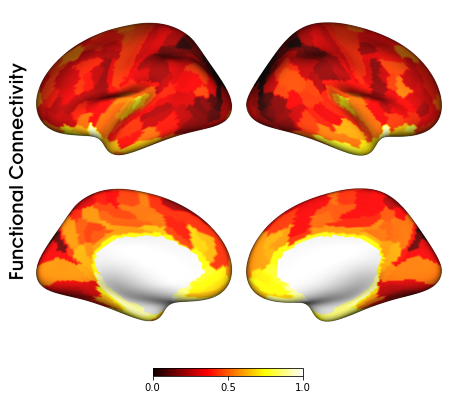

In [152]:
# Visualize
# plot both BF and geodic distance together

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Functional Connectivity']}, brightness=.8)
#p.add_layer(geodic_scaled_data.reshape([20484]), cmap='hot_r', cbar=True)
#p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
p.add_layer(gdist_df['functional'].values, cmap='hot', cbar=True)
#p.add_layer(gdist_df['structural'].values, cmap='hot', cbar=True)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'functional_connectivity_grid.png', dpi=300)

## Creating parcellated geodesic and myelin data to match func and diff data

In [99]:
#glasser_parc = fetch_parcellation("fsaverage5", "glasser", 360)

In [94]:
# load the hcp-mmp1 parcellation gii file
hcpmmp_lh = images.load_gifti(data_path + 'glasser_360_fsaverage5_lhlabel.gii')
hcpmmp_rh = images.load_gifti(data_path + 'glasser_360_fsaverage5_rhlabel.gii')

In [95]:
# combine lh and rh (and make the labels order consecutive)
hcpmmp_parcellation = images.relabel_gifti((hcpmmp_lh, hcpmmp_rh))

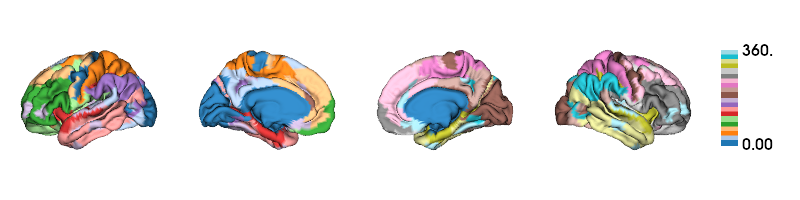

In [96]:
# visualize the parcellation data to double check
hm_lh, hm_rh = hcpmmp_parcellation
parc_L_data = hm_lh.agg_data()
parc_R_data = hm_rh.agg_data()
parc_data = np.concatenate((parc_L_data, parc_R_data))
surf_lh, surf_rh = load_fsa5()
plot_hemispheres(surf_lh, surf_rh, array_name=[parc_data], size=(800, 200), cmap=['tab20'], color_bar=True, embed_nb=True)

In [97]:
# create parcellater
hcpmmp = parcellate.Parcellater(hcpmmp_parcellation, 'fsaverage').fit()

In [98]:
gdist_df = pd.read_csv(results_path + 'rescaled_geodesic_myelin_func_struct_data.csv')

In [99]:
# get data
geodesic_scaled_data = gdist_df['geodesic'].values
myelin_scaled_data = gdist_df['myelin'].values
func_scaled_data = gdist_df['functional'].values
diff_scaled_data = gdist_df['structural'].values

In [100]:
geodesic_parc = hcpmmp.transform(geodesic_scaled_data, 'fsaverage', ignore_background_data=True)

In [101]:
myelin_parc = hcpmmp.transform(myelin_scaled_data, 'fsaverage', ignore_background_data=True)

In [102]:
func_parc = hcpmmp.transform(func_scaled_ctx, 'fsaverage', ignore_background_data=True)
diff_parc = hcpmmp.transform(diff_scaled_ctx, 'fsaverage', ignore_background_data=True)

### Visualize parcellated data

In [103]:
# setting up for cortical projection using brainspace
surf_lh, surf_rh = load_fsa5()

surf_labels_lh = nib.freesurfer.read_annot(data_path + 'lh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh = nib.freesurfer.read_annot(data_path + 'rh.HCP-MMP1_fsa10.annot')[0]
surf_labels_rh[surf_labels_rh != 0] += 180  # different labels for lh and rh
surf_labels = np.concatenate([surf_labels_lh, surf_labels_rh])

mask = surf_labels != 0  # discard medial wall

In [104]:
geodesic_parc_cortex = map_to_labels(geodesic_parc,surf_labels, mask=mask, fill=np.nan)
myelin_parc_cortex = map_to_labels(myelin_parc,surf_labels, mask=mask, fill=np.nan)

/tmp/ipykernel_7862/725244361.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


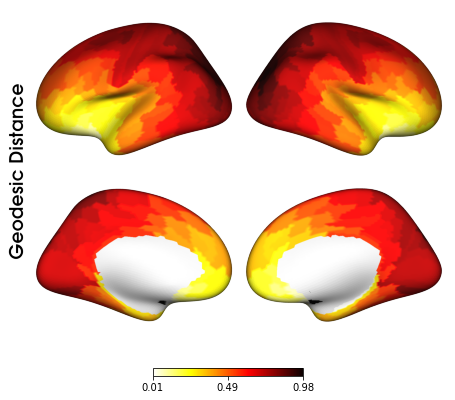

In [153]:
# Visualize

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), zoom=1.5, label_text={'left':['Geodesic Distance']}, brightness=.8)
p.add_layer(geodesic_parc_cortex, cmap='hot_r', cbar=True)
p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary', cbar=False)
#p.add_layer(myelin_parc_cortex, cmap='hot', cbar=True)
fig = p.build()
fig.show()
#fig.savefig(fig_path+'geodesic_dist_parc-hot_grid.png', dpi=300)

### Correlations

#### Yeo Network for color ref

In [110]:
from matplotlib.colors import ListedColormap
from brainstat.datasets import fetch_mask, fetch_template_surface
from brainstat.datasets import fetch_parcellation
from brainspace.plotting.surface_plotting import plot_hemispheres
from brainstat.datasets import fetch_yeo_networks_metadata

surfaces = fetch_template_surface("fsaverage5", join=False)
yeo_networks = fetch_parcellation("fsaverage5", "yeo", 7)
network_names, yeo_colormap = fetch_yeo_networks_metadata(7)
yeo_colormap_gray = np.concatenate((np.array([[0.7, 0.7, 0.7]]), yeo_colormap))
yeoCols = ListedColormap(yeo_colormap_gray)

/tmp/ipykernel_7862/267415264.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


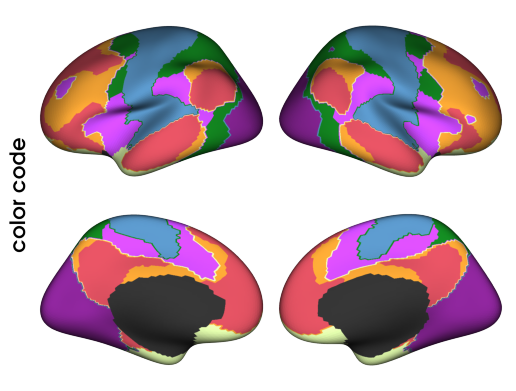

In [111]:
# Visualize network color ref

surfaces = fetch_fsaverage(density='10k')
lh, rh = surfaces['inflated']

p = Plot(lh, rh, size=(800, 600), label_text={'left':['color code']}, brightness=.8)
p.add_layer(yeo_networks, cmap=yeoCols, cbar=False)
# p.add_layer(geodic_scaled_data.reshape([20484]), cmap='hot_r', cbar=True)
# p.add_layer(BF_scaled_data.reshape([20484]), cmap='binary_r', cbar=False)
# p.add_layer(func_scaled_ctx.reshape([20484]), cmap='RdPu', cbar=True)
# p.add_layer(diff_scaled_ctx.reshape([20484]), cmap='GnBu', cbar=True)
fig = p.build()
fig.show()

In [112]:
network_parc = hcpmmp.transform(yeo_networks, 'fsaverage', ignore_background_data=True)

### scatter plots

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


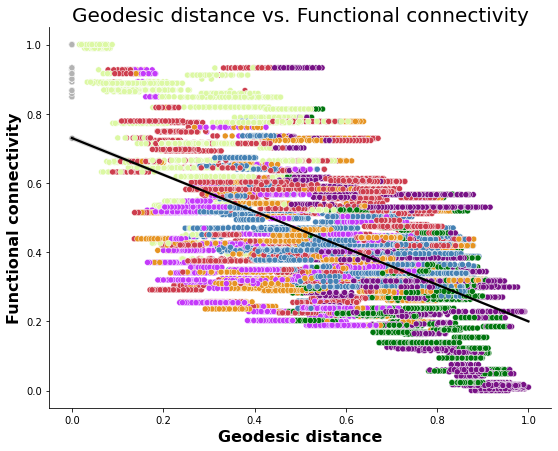

In [114]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(gdist_df['geodesic'], gdist_df['functional'], hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Functional connectivity', weight='bold', fontsize=16)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)

plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=gdist_df['geodesic'].values,
    y=gdist_df['functional'].values,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Geodesic_distance_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


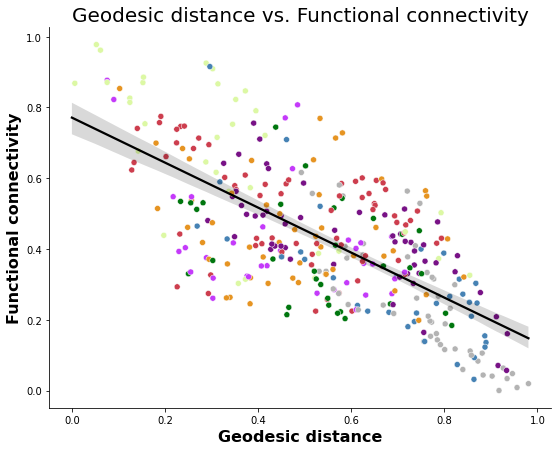

In [115]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, func_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)
ax1.set_ylabel('Functional connectivity', weight='bold', fontsize=16)

plt.title("Geodesic distance vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


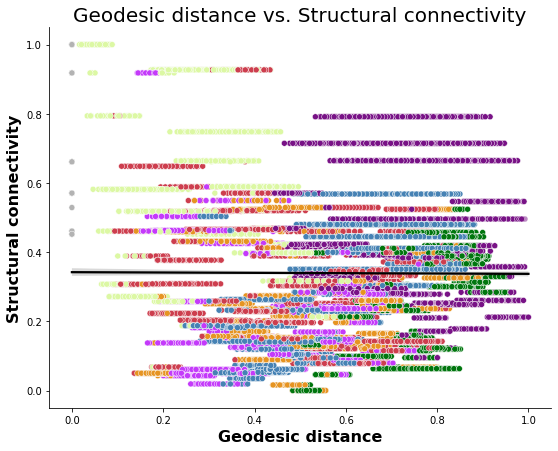

In [116]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(gdist_df['geodesic'], gdist_df['structural'], hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Structural connectivity', weight='bold', fontsize=16)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)

plt.title("Geodesic distance vs. Structural connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=gdist_df['geodesic'].values,
    y=gdist_df['structural'].values,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Geodesic_distance_vs_Structural_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


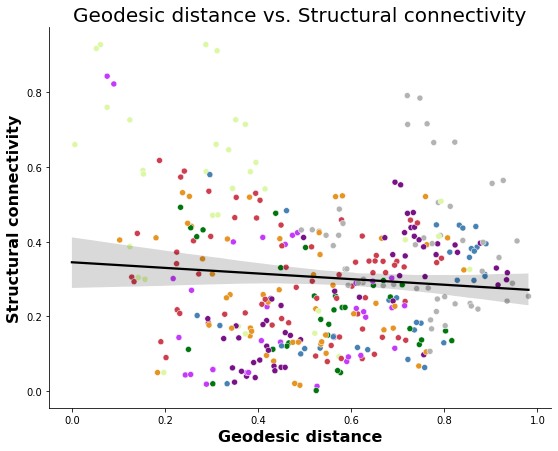

In [117]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(geodesic_parc, diff_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_ylabel('Structural connectivity', weight='bold', fontsize=16)
ax1.set_xlabel('Geodesic distance', weight='bold', fontsize=16)

plt.title("Geodesic distance vs. Structural connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=geodesic_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Geodesic_distance_vs_Structural_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


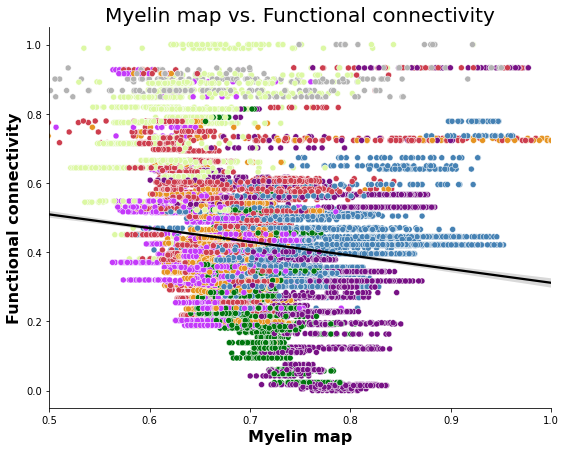

In [149]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(gdist_df['myelin'], gdist_df['functional'], hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlim(0.5,1.0)
ax1.set_xlabel('Myelin map', weight='bold', fontsize=16)
ax1.set_ylabel('Functional connectivity', weight='bold', fontsize=16)

plt.title("Myelin map vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=gdist_df['myelin'].values,
    y=gdist_df['functional'].values,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

#plt.savefig(fig_path + f'Myelin_map_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


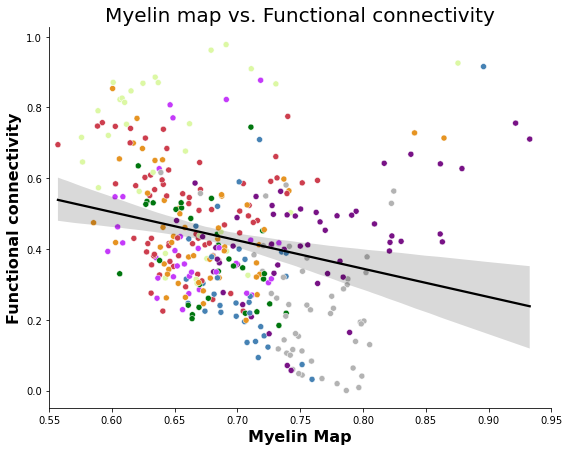

In [125]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(myelin_parc, func_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlim(0.55,0.95)
ax1.set_xlabel('Myelin Map', weight='bold', fontsize=16)
ax1.set_ylabel('Functional connectivity', weight='bold', fontsize=16)

plt.title("Myelin map vs. Functional connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=myelin_parc,
    y=func_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Myelin_map_vs_Functional_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


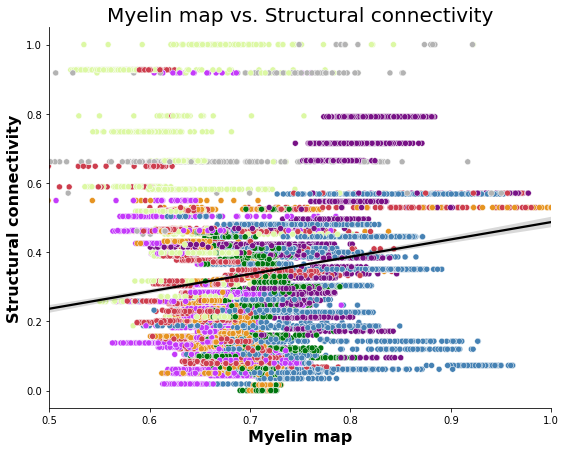

In [148]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(gdist_df['myelin'], gdist_df['structural'], hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlim(0.5,1.0)
ax1.set_xlabel('Myelin map', weight='bold', fontsize=16)
ax1.set_ylabel('Structural connectivity', weight='bold', fontsize=16)

plt.title("Myelin map vs. Structural connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=gdist_df['myelin'].values,
    y=gdist_df['structural'].values,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

#plt.savefig(fig_path + f'Myelin_map_vs_Structural_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


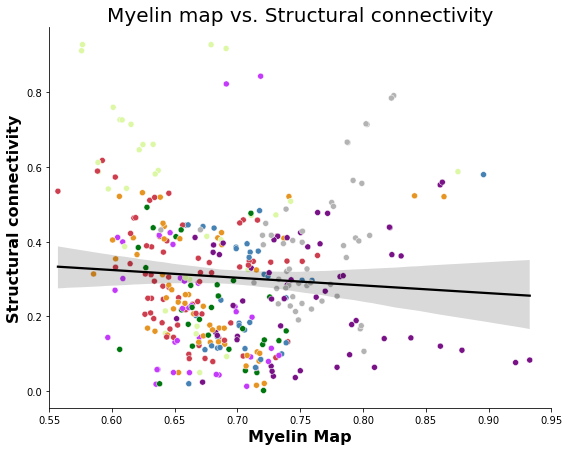

In [124]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(myelin_parc, diff_parc, hue=network_parc, palette=yeoCols)
ax1.legend([],[], frameon=False)
ax1.set_xlim(0.55,0.95)
ax1.set_xlabel('Myelin Map', weight='bold', fontsize=16)
ax1.set_ylabel('Structural connectivity', weight='bold', fontsize=16)

plt.title("Myelin map vs. Structural connectivity", fontsize=20)
# Add fit line
sns.regplot(
    x=myelin_parc,
    y=diff_parc,
    scatter=False, line_kws={'color': 'black'},
    ax=ax1)
sns.despine()

plt.savefig(fig_path + f'Parcellated_Myelin_map_vs_Structural_connectivity.png', dpi=300, bbox_inches='tight')

plt.show()

/home/ROBARTS/schakraborty/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


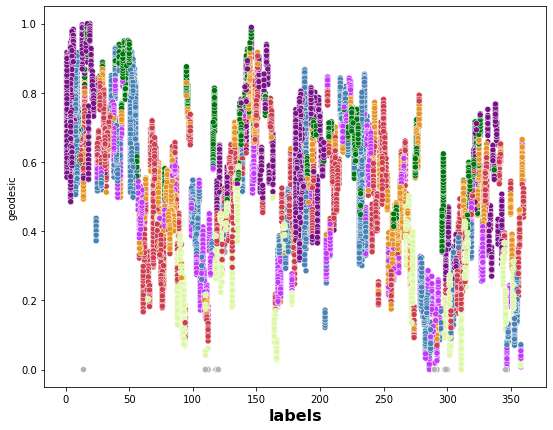

In [79]:
# Plot scatterplot colorcoded for XYZ coordinates
fig = plt.figure(figsize=(9,7))

ax1 = sns.scatterplot(gdist_df['labels'], gdist_df['geodesic'], hue=yeo_networks, palette=yeoCols)
ax1.legend([],[], frameon=False)
#ax1.set_ylabel('labels', weight='bold', fontsize=16)
ax1.set_xlabel('labels', weight='bold', fontsize=16)

plt.show()

### Null models

In [61]:
#geodesic_scaled_data = geodic_scaled_data.reshape([20484])
#func_scaled_data = func_scaled_ctx.reshape([20484])
#diff_scaled_data = diff_scaled_ctx.reshape([20484])

In [126]:
gdist_df = pd.read_csv(results_path + 'rescaled_geodesic_myelin_func_struct_data.csv')

In [127]:
geodesic_scaled_data = gdist_df['geodesic'].values
myelin_scaled_data = gdist_df['myelin'].values
func_scaled_data = gdist_df['functional'].values
diff_scaled_data = gdist_df['structural'].values

#### Geodesic Distance - whole brain

In [136]:
alex_geodesic_rotated = nulls.alexander_bloch(geodesic_scaled_data, atlas='fsaverage', density='10k', n_perm=10000, seed=1234)

In [137]:
fcgc_corr, fcgc_pval = stats.compare_images(geodesic_scaled_data,func_scaled_data, nulls=alex_geodesic_rotated)
fcgc_corr, fcgc_pval

(-0.557321576581757, 0.0403959604039596)

In [138]:
dcgc_corr, dcgc_pval = stats.compare_images(geodesic_scaled_data,diff_scaled_data, nulls=alex_geodesic_rotated)
dcgc_corr, dcgc_pval

(0.05961914058024589, 0.8742125787421258)

#### Geodesic Distance - parcellated 

In [129]:
geodesic_parc_rotated = nulls.alexander_bloch(geodesic_parc, atlas='fsaverage', density='10k',
                                n_perm=10000, seed=1234, parcellation=hcpmmp_parcellation)

In [130]:
pc_fcgc_corr, pc_fcgc_pval = stats.compare_images(geodesic_parc,func_parc, nulls=geodesic_parc_rotated)
pc_fcgc_corr, pc_fcgc_pval

(-0.6852893829345703, 0.007799220077992201)

In [131]:
pc_dcgc_corr, pc_dcgc_pval = stats.compare_images(geodesic_parc,diff_parc, nulls=geodesic_parc_rotated)
pc_dcgc_corr, pc_dcgc_pval

(-0.07626781612634659, 0.8536146385361464)

#### Myelin map - whole brain

In [139]:
alex_myelin_rotated = nulls.alexander_bloch(myelin_scaled_data, atlas='fsaverage', density='10k', n_perm=10000, seed=1234)

In [140]:
fcmc_corr, fcmc_pval = stats.compare_images(myelin_scaled_data,func_scaled_data, nulls=alex_myelin_rotated)
fcmc_corr, fcmc_pval

(-0.15758198255713743, 0.49245075492450757)

In [141]:
dcmc_corr, dcmc_pval = stats.compare_images(myelin_scaled_data,diff_scaled_data, nulls=alex_myelin_rotated)
dcmc_corr, dcmc_pval

(0.17519938575875313, 0.35936406359364065)

#### Myelin map - parcellated data

In [132]:
myelin_parc_rotated = nulls.alexander_bloch(myelin_parc, atlas='fsaverage', density='10k',
                                n_perm=10000, seed=1234, parcellation=hcpmmp_parcellation)

In [142]:
pc_fcmc_corr, pc_fcmc_pval = stats.compare_images(myelin_parc,func_parc, nulls=myelin_parc_rotated)
pc_fcmc_corr, pc_fcmc_pval

(-0.2503880262374878, 0.22027797220277973)

In [143]:
pc_dcmc_corr, pc_dcmc_pval = stats.compare_images(myelin_parc,diff_parc, nulls=myelin_parc_rotated)
pc_dcmc_corr, pc_dcmc_pval

(-0.07167429476976395, 0.7063293670632936)